# Mini Project - Pnuemonia Detection using CNN

## Step 1 : Import Libraries

In [3]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

## Step 2 : Read the dataset

In [5]:
import os
import pandas as pd

healthy_dirs = [
    r'chest_xray/test/NORMAL',
    r'chest_xray/train/NORMAL',
    r'chest_xray/val/NORMAL',
]

pneumonia_dir = [ 
    r'chest_xray/test/PNEUMONIA',
    r'chest_xray/train/PNEUMONIA',
    r'chest_xray/val/PNEUMONIA'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())


                                          filepaths  labels
0          chest_xray/test/NORMAL/IM-0031-0001.jpeg  Normal
1          chest_xray/test/NORMAL/IM-0025-0001.jpeg  Normal
2  chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg  Normal
3  chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg  Normal
4  chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [6]:
pneumonia_df.shape

(5856, 2)

In [7]:
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42)

In [8]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(4684, 2)
(1757, 2)
(1172, 2)
(4099, 2)


## Step 3 : Image Preprocessing

In [9]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 4684 validated image filenames belonging to 2 classes.
Found 1757 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [10]:
classes=list(train.class_indices.keys())
print (classes)

['Normal', 'Pneumonia']


In [11]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

## Step 4 : Create the model

In [12]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

In [13]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Step 5 : Train and Evaluate the model

In [14]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
1171/1171 [==============================] - ETA: 0s - loss: 0.4417 - accuracy: 0.8578

In [ ]:
model.evaluate(test, verbose=1)

440/440 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9512 - loss: 0.1699


[0.1481194645166397, 0.9595901966094971]

In [ ]:
model.save("pneumonia_Model.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

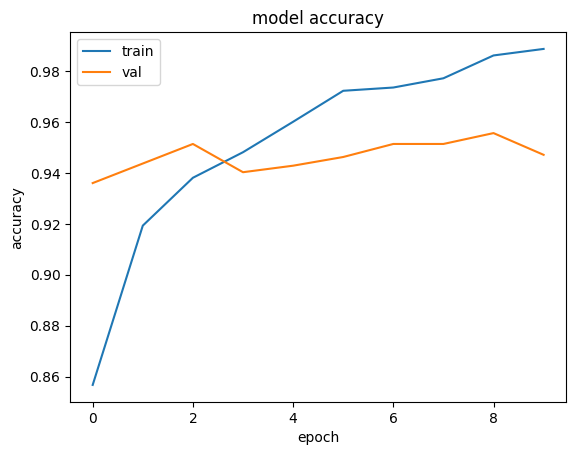

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

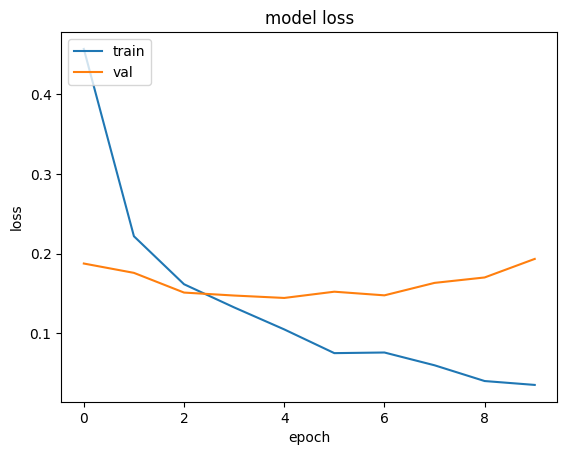

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.97      0.89      0.93       505
   Pneumonia       0.96      0.99      0.97      1252

    accuracy                           0.96      1757
   macro avg       0.96      0.94      0.95      1757
weighted avg       0.96      0.96      0.96      1757

Accuracy of the Model: 96.0%


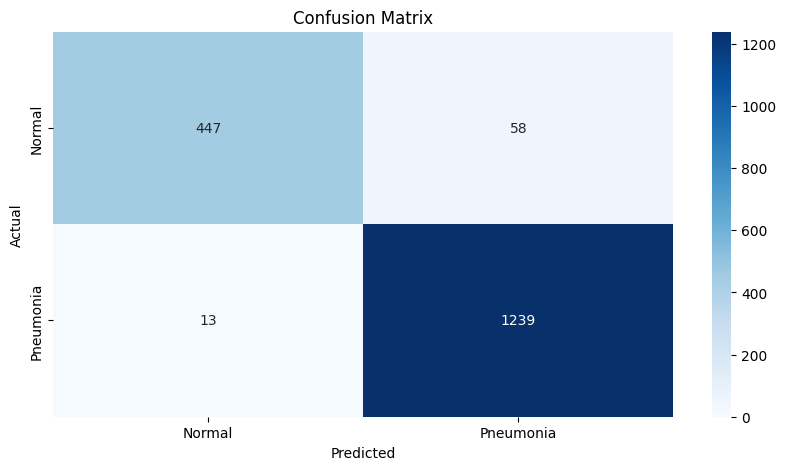

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()
